

# **DUO TEAM - HUMPBACKERS**


  - Anannyo Dey
  - Debasmit Roy


---



# **Mounting Drive, Package installations and Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install tensorflow_io
!pip install arlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 47.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 25 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [4

In [ ]:
! pip install git+https://github.com/qubvel/classification_models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-icou5om6
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-icou5om6
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 2.4 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20045 sha256=32f78307169224f44c4e487ce29333ef8dced4b0ed6f3657c55bf014870652fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-1acx9lcr/wheels/77/23/ad/afd2caf2877de1a21565559524b6435e5396579c14207062f3
Successfully built image-classifiers


In [ ]:
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c datafestintegration2023

 99% 1.75G/1.77G [00:10<00:00, 136MB/s]
100% 1.77G/1.77G [00:10<00:00, 179MB/s]


In [ ]:
import os
import pathlib
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.keras.utils import plot_model

import librosa
import librosa.display
import tensorflow_io as tfio
from tensorflow import keras

from skimage.restoration import denoise_wavelet
from arlpy import bf
import scipy
from classification_models.keras import Classifiers


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# **Signal Data Loading**

## Unizipping the zip file downloaded from Kaggle

In [ ]:
local_zip = '/content/datafestintegration2023.zip' 
zip_ref = zipfile.ZipFile(local_zip, 'r') 
zip_ref.extractall('/content/') 

In [ ]:
data_dir = '/content/train/train'
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['0' '1']


## Generator to fetch .wav signals from Directory 

In [ ]:
""""
The audio clips are 1 second or less at 16kHz. 
The output_sequence_length=60000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.
""""

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=512,
    validation_split=0.2,
    seed=0,
    output_sequence_length=60000,
    subset='both')

label_names = np.array(train_ds.class_names)
print("label names:", label_names)

Found 25946 files belonging to 2 classes.
Using 20757 files for training.
Using 5189 files for validation.
label names: ['0' '1']


In [ ]:
#This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
n_train = 20757
n_val = 5189

### Example .wav signal (output_sequence_length=60000)

In [ ]:
example_audio, example_labels = next(train_ds.as_numpy_iterator())

### Visualize 8 random loaded example_audio signals 

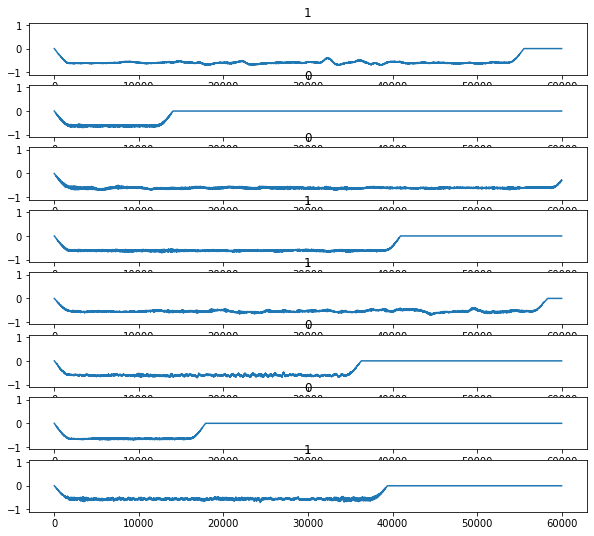

In [ ]:
n = 8 
fig, axes = plt.subplots(n, figsize=(10, 9))

for r in range(n):
  ax = axes[r]
  ax.plot(example_audio[r])
  label = example_labels[r]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

# **Creating Spectrogram**

## Spectrogram Utils

In [ ]:
# To plot waveforms
def plot_wav(waveform):
    timescale = np.arange(waveform.shape[0])
    plt.plot(timescale, waveform)
    plt.show()
    
# To plot log_mel_spectrograms
def plot_spec(log_mel_spectrograms):
  plt.show()
  plt.figure(figsize=(7, 5))
  librosa.display.specshow(log_mel_spectrograms.numpy().T, 
                          sr=2000, 
                          x_axis="linear")
  plt.colorbar(format="%+2.f")
  plt.show()

In [ ]:
# utiltiy function to normalize e tensor
def normalize(x):
  return (x-tf.reduce_min(x))/(tf.reduce_max(x)-tf.reduce_min(x))

# utiltiy function to normalize followed by denoising the waveform signal
def processWave(wavform):
  wavform = normalize(wavform)
  wavform = denoise_wavelet(tf.convert_to_tensor(wavform).numpy(), method='VisuShrink', mode='soft', wavelet_levels=2, wavelet='sym8', rescale_sigma=True)
  return wavform

# utiltiy function to normalize followed by denoising the log spectrograms
def processSpec(logspec):
  logspec = normalize(logspec)
  logspec = denoise_wavelet(tf.convert_to_tensor(logspec).numpy(), method='VisuShrink', mode='soft', wavelet_levels=2, wavelet='sym8', rescale_sigma=True)
  return logspec

# def beamform(spec):
#   return bf.delay_and_sum(spec, 2000,64)

# def gaussSmooth(spec):
#   return scipy.ndimage.gaussian_filter(spec,sigma=3)

In [ ]:
# a utility function for converting waveforms to log mel spectrograms

def getMel(waveform,plot=False):
  waveform = processWave(waveform)## NOT TF
  sample_rate = 2000
  # A 1024-point STFT with frames of 64 ms and 75% overlap.
  stfts = tf.signal.stft(waveform, frame_length=512, frame_step=64,fft_length=1024)
  spectrograms = tf.abs(stfts)
  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = stfts.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0, 1000.0, 64
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
    upper_edge_hertz)
  mel_spectrograms = tf.tensordot(
    spectrograms, linear_to_mel_weight_matrix, 1)
  mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
  log_mel_spectrograms = processSpec(log_mel_spectrograms)## NOT TF

  if plot==True:
    timescale = np.arange(waveform.shape[0])
    plt.plot(timescale, waveform)
    plt.show()
    plt.figure(figsize=(7, 5))
    librosa.display.specshow(tf.convert_to_tensor(log_mel_spectrograms).numpy().T, 
                            sr=2000, 
                            x_axis="linear")
    plt.colorbar(format="%+2.f")
    plt.show()
    plt.imshow(log_mel_spectrograms)
    plt.show()

  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  return log_mel_spectrograms[..., tf.newaxis]

## Visualize 41st Example Audio signal

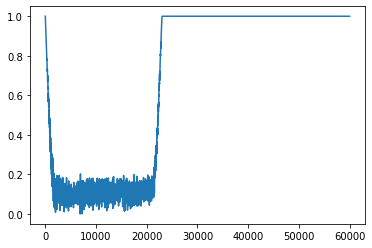

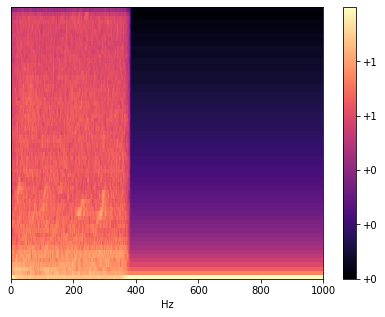

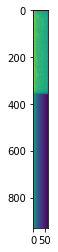

Label: 0
Waveform shape: (60000,)
Spectrogram shape: (930, 64, 1)
Audio playback


In [ ]:
ind = 41
label = label_names[example_labels[ind]]
waveform = example_audio[ind]
logspectrogram = getMel(waveform,plot=True)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', logspectrogram.shape)
print('Audio playback')

display.display(display.Audio(waveform,rate=16000))
display.display(display.Audio(processWave(waveform),rate=16000))

## Spectrogram Generation

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (audio, label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


#### To store the Noise Reduced Spectrograms in Numpy Array from Train Dataset

In [ ]:
x_train, y_train = (next(train_spectrogram_ds.as_numpy_iterator()))
x_train = getMel(x_train)

for i in range(n_train//512):
  print("step: ",i)
  x_train_temp, y_train_temp = next(train_spectrogram_ds.as_numpy_iterator());
  x_train_temp = getMel(x_train_temp)
  x_train = np.concatenate((x_train,x_train_temp));
  y_train = np.concatenate((y_train,y_train_temp));

step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  11
step:  12
step:  13
step:  14
step:  15
step:  16
step:  17
step:  18
step:  19
step:  20
step:  21
step:  22
step:  23
step:  24
step:  25
step:  26
step:  27
step:  28
step:  29
step:  30
step:  31
step:  32
step:  33
step:  34
step:  35
step:  36
step:  37
step:  38
step:  39


#### To store the Noise Reduced Spectrograms in Numpy Array from Validation Dataset

In [ ]:
x_val, y_val = (next(val_spectrogram_ds.as_numpy_iterator()))
x_val = getMel(x_val)

for i in range(n_val//512):
  print("step: ",i)
  x_val_temp, y_val_temp = (next(val_spectrogram_ds.as_numpy_iterator()));
  x_val_temp = getMel(x_val_temp)
  x_val = np.concatenate((x_val,x_val_temp));
  y_val = np.concatenate((y_val,y_val_temp));

step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9


#### Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:


In [ ]:
TRAIN_BUF=1000
BATCH_SIZE=64

train_spectrogram_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(TRAIN_BUF).batch(BATCH_SIZE, drop_remainder=True)
val_spectrogram_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(TRAIN_BUF).batch(BATCH_SIZE, drop_remainder=True)

### Example Spectrogram

In [ ]:
example_spectrograms, example_spect_labels = next(val_spectrogram_ds.as_numpy_iterator())

# **CRNN MODEL**

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

x_in = tf.keras.layers.Input(shape = input_shape) # Input layer
x = tf.keras.layers.BatchNormalization()(x_in)
for i in range(4): # Four convolutional layer modules.
    x = tf.keras.layers.Conv2D(16*(2 ** i), (3,3))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ELU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x =tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(128, (1,1))(x)
x_branch_1 = tf.keras.layers.AveragePooling2D()(x)
x_branch_2 = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.concatenate([x_branch_1, x_branch_2]) # Take use of both pooling by concate
x = tf.keras.layers.Reshape((28, 256))(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x) # Output layer

model1 = tf.keras.models.Model(inputs = x_in, outputs = x)
model1.summary()

Input shape: (930, 64, 1)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 930, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 930, 64, 1)  4           ['input_5[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 conv2d_8 (Conv2D)              (None, 928, 62, 16)  160         ['batch_normalization_8[0][0]']  
                                                                 

In [ ]:
model = model1

# **Model Training**

In [ ]:
# CustomCallback to stop training once we hit 98.63% validation accuracy

class CustomCallback(keras.callbacks.Callback):
 def on_epoch_end(self, epoch, logs={}):
   if(logs.get('val_accuracy')>0.986):
     print("\nReached 98.6% accuracy so cancelling training!")
     self.model.stop_training = True

In [ ]:
# Learning Rate Scheduler

def scheduler(epoch, lr):
  if epoch < 12:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
# Configure the Keras model with the RMSprop optimizer and the binary_crossentropy loss:

model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Running the model with epoch = 20

EPOCHS = 20
history1 = model.fit(train_spectrogram_ds,validation_data=val_spectrogram_ds,epochs=EPOCHS,verbose = 1,callbacks=[CustomCallback(), 
                                                                                                                 tf.keras.callbacks.LearningRateScheduler(scheduler)])

Epoch 1/20
328/328 [==============================] - 29s 56ms/step - loss: 0.2427 - accuracy: 0.8949 - val_loss: 1.0858 - val_accuracy: 0.6465 - lr: 0.0010
Epoch 2/20
328/328 [==============================] - 17s 52ms/step - loss: 0.1140 - accuracy: 0.9561 - val_loss: 0.1024 - val_accuracy: 0.9648 - lr: 0.0010
Epoch 3/20
328/328 [==============================] - 17s 52ms/step - loss: 0.0912 - accuracy: 0.9643 - val_loss: 0.1016 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 4/20
328/328 [==============================] - 17s 52ms/step - loss: 0.0813 - accuracy: 0.9681 - val_loss: 0.1178 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 5/20
328/328 [==============================] - 17s 52ms/step - loss: 0.0731 - accuracy: 0.9719 - val_loss: 0.1016 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 6/20
328/328 [==============================] - 17s 52ms/step - loss: 0.0639 - accuracy: 0.9749 - val_loss: 0.1812 - val_accuracy: 0.9512 - lr: 0.0010
Epoch 7/20
328/328 [==============================] - 17s 

In [ ]:
# Reconfigure the Keras model with the SGD optimizer and the binary_crossentropy loss:

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Running the model with epoch = 15
EPOCHS = 15
history2 = model.fit(train_spectrogram_ds,validation_data=val_spectrogram_ds,epochs=EPOCHS,verbose = 1,callbacks=[CustomCallback(), 
                                                                                                                 tf.keras.callbacks.LearningRateScheduler(scheduler)])

Epoch 1/15
  5/328 [..............................] - ETA: 18s - loss: 0.0015 - accuracy: 1.0000    

328/328 [==============================] - 20s 51ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.1282 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 2/15
328/328 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9989
Reached 98% accuracy so cancelling training!
328/328 [==============================] - 17s 51ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.1329 - val_accuracy: 0.9805 - lr: 0.0010


In [ ]:
#rerunning
EPOCHS = 20
history1 = model.fit(train_spectrogram_ds,validation_data=val_spectrogram_ds,epochs=EPOCHS,verbose = 1,callbacks=[CustomCallback(), 
                                                                                                                 tf.keras.callbacks.LearningRateScheduler(scheduler)])

Epoch 1/20
  5/328 [..............................] - ETA: 18s - loss: 0.0069 - accuracy: 0.9969

328/328 [==============================] - 23s 56ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0847 - val_accuracy: 0.9844 - lr: 4.4933e-04
Epoch 2/20
327/328 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9995
Reached 98.6% accuracy so cancelling training!
328/328 [==============================] - 17s 52ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0838 - val_accuracy: 0.9863 - lr: 4.4933e-04


# **Evaluation**

#### Let's plot the training and validation loss curves to check how your model has improved during training:



In [ ]:
metrics = history1.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history1.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history1.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Run the model on the validation set and check the model's performance:



In [ ]:
x_temp, y_temp = (next(val_spectrogram_ds.as_numpy_iterator()))
y_pred = np.squeeze((model(x_temp)>0.5).numpy().astype(int))
y_true = y_temp

for i in range(n_val//BATCH_SIZE):
  x_temp, y_temp = (next(val_spectrogram_ds.as_numpy_iterator()));
  y_pred = np.concatenate((y_pred,np.squeeze((model(x_temp)>0.5).numpy().astype(int))));
  y_true = np.concatenate((y_true,y_temp));

To Get Additional Performance Metrics In Validation


In [ ]:
from imblearn.metrics import classification_report_imbalanced

all_report = classification_report_imbalanced(y_true, y_pred)

In [ ]:
print(all_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.99      0.97      0.98      0.98      0.96      2544
          1       0.99      0.97      0.99      0.98      0.98      0.95      2704

avg / total       0.98      0.98      0.98      0.98      0.98      0.96      5248



# **Testing**

# Test Data Loading

In [ ]:
BATCH_SIZE_TEST = 2000;

In [ ]:
import torch
import torchaudio

In [ ]:
def pad_trunc(aud, max_ms):
  sig, sr = aud
  num_rows, sig_len = sig.shape
  max_len = sr//1000 * max_ms

  if (sig_len > max_len):
    sig = sig[:,:max_len]

  elif (sig_len < max_len):
    pad = max_len - sig_len
    pad_end = torch.zeros((num_rows, pad))

    sig = torch.cat((sig, pad_end), 1)
    
  return sig

def decode(audio_file):
  sig, sr = torchaudio.load(audio_file)
  return pad_trunc((sig, sr),max_ms=30000)

In [ ]:
path = '/content/test/test/'
tag = []
signals = []

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
            rel_path = dirname.replace(path, "")
            tag.append(int(filename.replace(".wav","")))
            signals.append(decode(path+filename).numpy())

signals = np.array(signals)
tag = np.array(tag)

In [ ]:
TEST_BUF=2000
test_ds = tf.data.Dataset.from_tensor_slices((signals,tag)).batch(BATCH_SIZE_TEST, drop_remainder=True)

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=1)
  return audio, labels

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
x_test, id_test = (next(test_ds.as_numpy_iterator()))

x_test0 = getMel(x_test[0:500])
x_test1 = getMel(x_test[500:1000])
x_test2 = getMel(x_test[1000:1500])
x_test3 = getMel(x_test[1500:2000])

x_test = np.concatenate([x_test0,x_test1,x_test2,x_test3])

In [ ]:
x_test = np.load('/content/drive/MyDrive/specs/x_test.npy')
id_test = np.load('/content/drive/MyDrive/specs/id_test.npy')

# Running model on test data

In [ ]:
TEST_BUF=2000
test_spectrogram_ds = tf.data.Dataset.from_tensor_slices((x_test,id_test)).batch(BATCH_SIZE_TEST, drop_remainder=True)

In [ ]:
x_temp, y_temp = (next(test_spectrogram_ds.take(1).as_numpy_iterator()))

y_pred0 = np.squeeze((model(x_temp[0:500])>0.5).numpy().astype(int))
y_pred1 = np.squeeze((model(x_temp[500:1000])>0.5).numpy().astype(int))
y_pred2 = np.squeeze((model(x_temp[1000:1500])>0.5).numpy().astype(int))
y_pred3 = np.squeeze((model(x_temp[1500:2000])>0.5).numpy().astype(int))

y_pred = np.concatenate([y_pred0,y_pred1,y_pred2,y_pred3])

y_true = y_temp

# **Generating submission file**

In [ ]:
body = np.vstack((y_true,y_pred)).T

In [ ]:
np.savetxt('submission.csv', body.astype(int), fmt='%i', delimiter=",")